In [1]:
## MP 573 Part 2, Lecture 9b: Gauss-Newton N-D optimization
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import time

font = {'weight' : 'normal',
        'size'   : 12}
np.set_printoptions(precision=2)

In [2]:
# Let's define a 2D function to be minimized
def myfunction(x,b,smeas):
    A = x[0];
    D = x[1];
    s = A*np.exp(-D*b*1E-3)
#    print(s)
    r = s - smeas
    f = (la.norm(r))**2
    J = np.concatenate((np.exp(-D*b*1E-3),-1E-3*A*(b*np.exp(-D*b*1E-3))),axis=1)
    return f, r, J

Optimal solution: A =  2.0 , D:  1.52
[[  0.]
 [100.]
 [200.]
 [300.]
 [400.]
 [500.]]
[[2.  ]
 [1.72]
 [1.48]
 [1.28]
 [1.1 ]
 [0.94]]


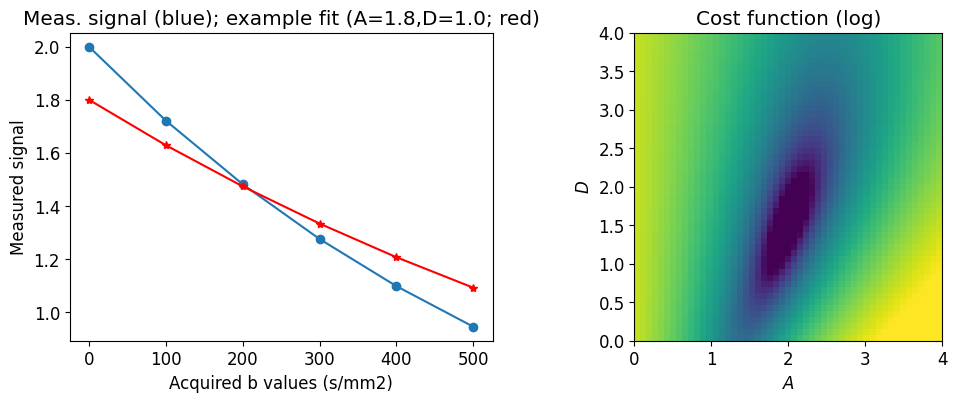

In [3]:
##### Let's plot the function
N = 51
xmin = 0.0
xmax = 4.0
xval = np.linspace(xmin,xmax,N)
As, Ds = np.meshgrid(xval,np.flip(xval))

K = 6 # Number of acquired (simulated) data points
b = np.zeros((K,1))
b[0] = 0
b[1] = 100
b[2] = 200
b[3] = 300
b[4] = 400
b[5] = 500

Atrue = 2
Dtrue = 1.5
smeas = Atrue*np.exp(-Dtrue*b*1E-3)


f2D = np.zeros((N,N))
for k1 in range(0,N):
    for k2 in range(0,N):
        curA = As[k1,k2]
        curD = Ds[k1,k2]
        curf,r,J = myfunction([curA,curD],b,smeas)
        f2D[k1,k2] = curf

plt.figure(figsize=(12,4))
plt.rc('font', **font)
plt.subplot(1,2,1)
plt.plot(b,smeas,'o-')
plt.plot(b,1.8*np.exp(-1.0*b*1E-3),'*-r')
plt.xlabel('Acquired b values (s/mm2)')
plt.ylabel('Measured signal')
plt.title('Meas. signal (blue); example fit (A=1.8,D=1.0; red)')
plt.subplot(1,2,2)
plt.imshow(np.log(f2D),extent = [xmin, xmax, xmin, xmax],vmin=-2, vmax=3)
plt.xlabel('$A$')
plt.ylabel('$D$');
plt.title('Cost function (log)')

# Find the optimal solution over our discretized array
imin = np.argmin(f2D)
x0ind,x1ind = np.unravel_index(imin, f2D.shape)
Ahat = As[x0ind,x1ind]
Dhat = Ds[x0ind,x1ind]
print("Optimal solution: A = ", f"{Ahat:.3}" , ", D: ", f"{Dhat:.3}")

print(b)
print(smeas)

## Steepest Descent algorithm

In [4]:
## Initialize
xnew = np.zeros((2,1))
xnew[0] = smeas[0]
xnew[1] = 2.5
allf = [myfunction(xnew, b, smeas)[0]]
MAX_SD_ITER = 10;

Algorithm: SD (one iteration).
Current guess (white dot): A =  [2.29] , D =  [2.33]


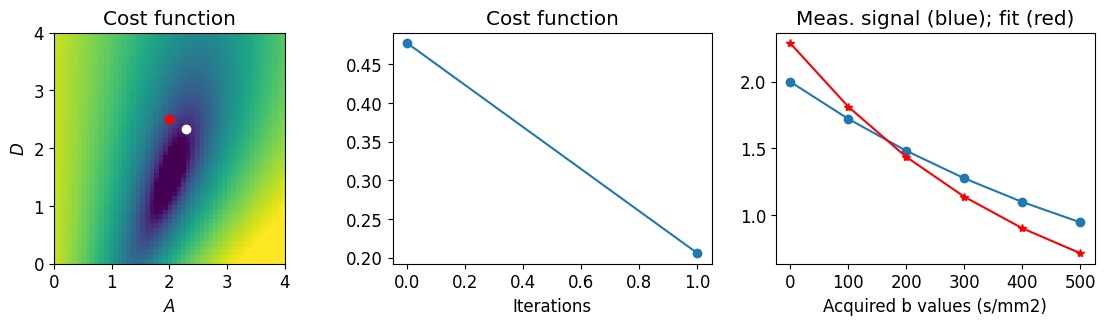

In [5]:
# This cell runs a single iteration (run it several times to see several iterations)
#for kiter in range(MAX_SD_ITER): # Uncomment this (and indent the rest) to put in a loop
print("Algorithm: SD (one iteration).")
xold = xnew
f,r,J = myfunction(xold,b,smeas)
g = (J.T).dot(r)
#    print("Previous guess (red dot): A = ", xold[0] , ", D = ", xold[1])

# Here we normalize the gradient. Not really needed but helps guess reasonable step size for line search. 
g = g/np.linalg.norm(g); 

# Here's the line search from a couple lectures ago
# Set algorithm parameters and initialize arrays
MAX_ITER = 100
MIN_XDIF = 1E-8
a0 = 0;
b0 = 10;
rho = 0.382;

# Line search iterations
k=0;
dx = MIN_XDIF + 1;
while k<MAX_ITER and np.abs(dx) > MIN_XDIF:
    a1 = a0 + rho*(b0-a0); # Note my implementation does not take advantage of the golden section cleverness, for simplicity
    b1 = b0 - rho*(b0-a0);
    fa = myfunction(xold - a1*g, b, smeas)[0];
    fb = myfunction(xold - b1*g, b, smeas)[0];  

    if fb<fa:
        a0 = a1;
    else:
        b0 = b1;
    k = k+1;
    dx = b0-a0;

# SD update
xnew = xold - (a0+b0)/2*g;
print("Current guess (white dot): A = ", xnew[0] , ", D = ", xnew[1])
allf.append(myfunction(xnew, b, smeas)[0])


# Plot it
plt.figure(figsize=(14,3))
plt.tight_layout()
plt.rc('font', **font)
plt.subplot(1,3,1)
plt.imshow(np.log(f2D),extent = [xmin, xmax, xmin, xmax],vmin=-2, vmax=3)
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w')
plt.title('Cost function')
plt.xlabel('$A$')
plt.ylabel('$D$');
plt.subplot(1,3,2)
plt.plot(allf,'o-')
plt.xlabel('Iterations')
plt.title('Cost function');

plt.subplot(1,3,3)
plt.plot(b,smeas,'o-')
plt.plot(b,xnew[0]*np.exp(-xnew[1]*b*1E-3),'*-r')
plt.xlabel('Acquired b values (s/mm2)')
plt.title('Meas. signal (blue); fit (red)');


### Gauss-Newton algorithm: Jacobian-based quadratic approximation and update

A very common type of optimization problem consists of fitting a nonlinear signal model to a set of acquired data using least-squares fitting. In this type of problem, our cost function $f(\mathbf{x})$ can be written as follows:

$$f(\mathbf{x}) = \sum_{k=1}^K r_k (\mathbf{x} )^2 = \mathbf{r} (\mathbf{x})^T \mathbf{r} (\mathbf{x})$$

where $\mathbf{r} (\mathbf{x}) = [r_1 (\mathbf{x} ), \cdots, r_K (\mathbf{x} )]^T$. This type of problem often arises in fitting nonlinear signal models to acquired data $\mathbf{s_{meas}}$, as follows: $r_k = f(\mathbf{x}, \mathbf{\theta_k}) - s_{meas,k}  $


Note that in this problem we are seeking to fit $K$ data points (ie: drive each of the $r_k$ close to zero) using a set of $N$ variables (each of the entries $x_n$ in our $\mathbf{x}$ vector). Importantly, this type of structure in our objective function allows us to efficiently calculate the gradient and the Hessian at arbitrary points. An important tool to help us calculate these quantities is the Jacobian matrix.

The Jacobian matrix for a problem where we try to fit $K$ data points using a set of $N$ variables is the $K \times N$ matrix given by:

$$ \mathbf{J}(\mathbf{x}) = \left[ \begin{array}{ccc}
    \frac{\partial r_1}{\partial x_1}(\mathbf{x}) & \cdots &  \frac{\partial r_1}{\partial x_N}(\mathbf{x}) \\
    \vdots & \ddots & \vdots \\
     \frac{\partial r_K}{\partial x_1}(\mathbf{x}) & \cdots &  \frac{\partial r_K}{\partial x_N}(\mathbf{x}) 
   \end{array} \right]$$

Importantly, the gradient for a nonlinear least-squares problem can be written as:
$$ \nabla f(\mathbf{x}) = 2 \mathbf{J}(\mathbf{x})^T \, \mathbf{r}(\mathbf{x}) $$
and the Hessian can be written as:
$$ \nabla^2 f(\mathbf{x}) = 2 \left(  \mathbf{J}(\mathbf{x})^T \, \mathbf{J}(\mathbf{x}) + \mathbf{S}(\mathbf{x}) \right) $$
where $\mathbf{S}(\mathbf{x})$ is the $N \times N$ matrix defined as:
$$\mathbf{S}(\mathbf{x}) = \sum_{k=1}^K r_k(\mathbf{x}) \, \nabla^2  r_k(\mathbf{x})$$
Oftentimes, the second component of the Hessian ($\mathbf{S}(\mathbf{x})$) is small compared to the first component ($\mathbf{J}(\mathbf{x})^T \, \mathbf{J}(\mathbf{x})$). In such situations, it is warranted to drop this second component leading to an approximated version of the Hessian that depends solely on the Jacobian matrix:
$$ \nabla^2 f(\mathbf{x}) \approx 2  \mathbf{J}(\mathbf{x})^T \, \mathbf{J}(\mathbf{x}) $$
Using this approximation for non-linear least-squares optimization problems leads to the so-called Gauss-Newton algorithm, with the following iteration update:
$$ \mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} - (\mathbf{J}(\mathbf{x})^T \, \mathbf{J}(\mathbf{x}) )^{-1} \, \mathbf{J}(\mathbf{x})^T \, \mathbf{r}(\mathbf{x})$$
which does not require the calculation of second derivatives, and yet provides good performance (rapid convergence) for a wide variety of nonlinear least-squares fitting algorithms. 

In [6]:
## Initialize
xnew = np.zeros((2,1))
xnew[0] = smeas[0]
xnew[1] = 2.5
allf = [myfunction(xnew, b, smeas)[0]]
MAX_GN_ITER = 10;

Algorithm: Gauss-Newton (one iteration)
Previous guess (red dot): A =  [2.] , D =  [2.5]
Current guess (white dot): A =  [1.98] , D =  [1.27]


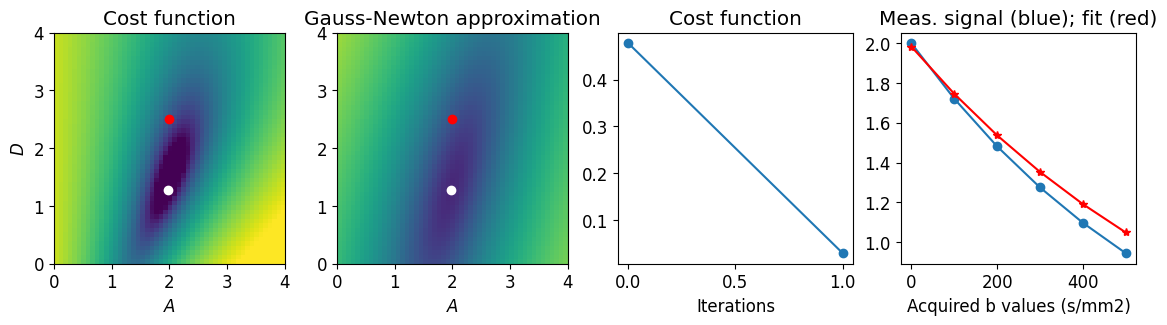

In [7]:
# This cell runs a single iteration (run it several times to see several iterations)
#for kiter in range(MAX_GN_ITER): # Uncomment this (and indent the rest) to put in a loop
print('Algorithm: Gauss-Newton (one iteration)')
xold = xnew
f,r,J = myfunction(xold,b,smeas)
g = (J.T).dot(r)
print("Previous guess (red dot): A = ", xold[0] , ", D = ", xold[1])
if la.norm(g)>0.000001:
    mu = 0; # Set to > 0 for Levenverg-Marquardt
    H = (J.T.dot(J) + mu*np.identity(2));
    xnew = xold - la.inv(H).dot(g)
else: 
    print('Done: not moving anymore')
print("Current guess (white dot): A = ", xnew[0] , ", D = ", xnew[1])

allf.append(myfunction(xnew, b, smeas)[0])

# Calculate the second order approximation implicit in Newton's method
v0 = (As-xold[0])
v1 = (Ds-xold[1])
fNewton = f + v0*g[0] + v1*g[1] + 0.5*(H[0,0]*(v0**2) + H[0,1]*v0*v1 + H[1,0]*v0*v1 + H[1,1]*(v1**2)) 

# Plot it
plt.figure(figsize=(14,3))
plt.tight_layout()
plt.rc('font', **font)
plt.subplot(1,4,1)
plt.imshow(np.log(f2D),extent = [xmin, xmax, xmin, xmax],vmin=-2, vmax=3)
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w')
plt.title('Cost function')
plt.xlabel('$A$')
plt.ylabel('$D$');
plt.subplot(1,4,2)
plt.imshow(np.log(fNewton),extent = [xmin, xmax, xmin, xmax],vmin=-2, vmax=3)
plt.title('Gauss-Newton approximation');
plt.xlabel('$A$')
plt.scatter(xold[0],xold[1],color='r')
plt.scatter(xnew[0],xnew[1],color='w')
plt.subplot(1,4,3)
plt.plot(allf,'o-')
plt.xlabel('Iterations')
plt.title('Cost function');
plt.subplot(1,4,4)
plt.plot(b,smeas,'o-')
plt.plot(b,xnew[0]*np.exp(-xnew[1]*b*1E-3),'*-r')
plt.xlabel('Acquired b values (s/mm2)')
plt.title('Meas. signal (blue); fit (red)');